## ***module import/install***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# konlpy 설치
## https://devocean.sk.com/blog/techBoardDetail.do?ID=164059
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2023-08-28 08:07:27--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2023-08-28 08:07:27--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0a27ccd6a694bb99dd1ff990a1.dl.dropboxusercontent.com/cd/0/get/CCpwvHWZAQgzDcBVH5B6uNJBYKFRPE2aMWBY4ebFhZgiEImHMKZ1pdkD_VA2paoYg3XxgsXByHitHN_gfZOFRXlKo2LaxmfKjJ_q4YHm6_9XYar3lJFLW44BeuM1o7CxlhW1vu-fa4ZU6CpCCRefNV-d/file?dl=1# [following]
--2023-08-28 08:07:28--  https://uc0a27ccd6a694bb99dd1ff990a1.dl.dropboxusercontent.com/cd/0/get/CCpwvHWZAQgzDcBVH5B6uNJBYKFRPE2aMWBY4ebFhZgiEImHMKZ1

In [3]:
from konlpy.tag import Kkma, Okt, Komoran
from collections import Counter
from wordcloud import WordCloud
from nltk import FreqDist

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import statistics
import re

In [4]:
# 시각화 폰트설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
font_path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
font_name = fm.FontProperties(fname = font_path, size = 10).get_name()
print(font_name)
plt.rc('font', family = font_name)

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

## ***data load & EDA***

### 0. Dataset 관찰



In [5]:
file_path = "/content/drive/MyDrive/KUBIG-DLcontest/dataset/"
train_df = pd.read_csv(file_path + "train_data.csv")
train_df.head(10)

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
5,5,팔레스타인 가자지구서 16세 소년 이스라엘군 총격에 사망,4
6,6,인도 48년 만에 파키스탄 공습…테러 캠프 폭격종합2보,4
7,7,美대선 TV토론 음담패설 만회실패 트럼프…사과 대신 빌클린턴 공격해 역효과,4
8,8,푸틴 한반도 상황 진전 위한 방안 김정은 위원장과 논의,4
9,9,특검 면죄부 받은 트럼프 스캔들 보도 언론 맹공…국민의 적,4


In [6]:
test_df = pd.read_csv(file_path + "test_data.csv")
test_df.head(10)

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간
5,45659,야외서 생방송 하세요…액션캠 전용 요금제 잇따라
6,45660,월드컵 태극전사 16강 전초기지 레오강 입성종합
7,45661,미세먼지 속 출근길
8,45662,왓츠앱稅 230원에 성난 레바논 민심…총리사퇴로 이어져종합2보
9,45663,베트남 경제 고성장 지속…2분기 GDP 6.71% 성장


In [7]:
topic_dict = pd.read_csv(file_path + "topic_dict.csv")
topic_dict

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [8]:
# merge train data with topic
train_df = train_df.merge(topic_dict, on = 'topic_idx')
train_df.head()

,index,title,topic_idx,topic
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,세계
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,세계
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,세계
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,세계


In [9]:
# data shape
print(train_df.shape)
print(test_df.shape)

(45654, 4)
(9131, 2)


### 1. 결측치 확인

In [10]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train_df)

결측치가 존재하지 않습니다


### 2. 중복데이터 확인

In [11]:
# train data
print(len(train_df), train_df['title'].nunique())
print(len(test_df), test_df['title'].nunique())

45654 45654
9131 9131


### 3. EDA

세계      7629
사회      7362
스포츠     6933
정치      6751
경제      6222
생활문화    5933
IT과학    4824
Name: topic, dtype: int64


<Axes: xlabel='topic', ylabel='count'>

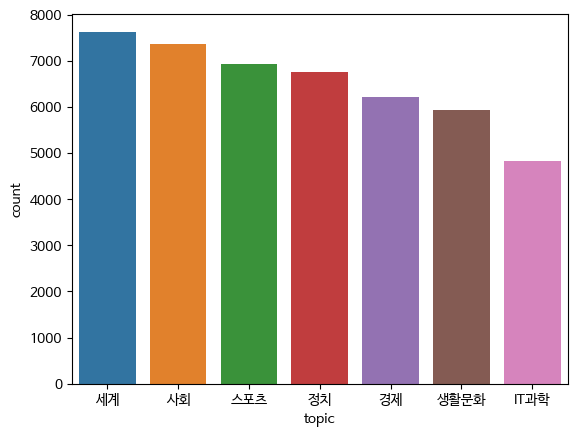

In [12]:
# topic_idx 빈도수
print(train_df['topic'].value_counts())
sns.countplot(data = train_df, x = 'topic', order = train_df['topic'].value_counts().index)

In [13]:
# 단어 빈도수
train_df['len'] = train_df['title'].apply(lambda x: len(x))
train_df['word_cnt'] = train_df['title'].apply(lambda x: len(x.split()))
train_df.head()

,index,title,topic_idx,topic,len,word_cnt
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계,24,5
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,세계,30,6
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,세계,30,8
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,세계,32,7
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,세계,25,7


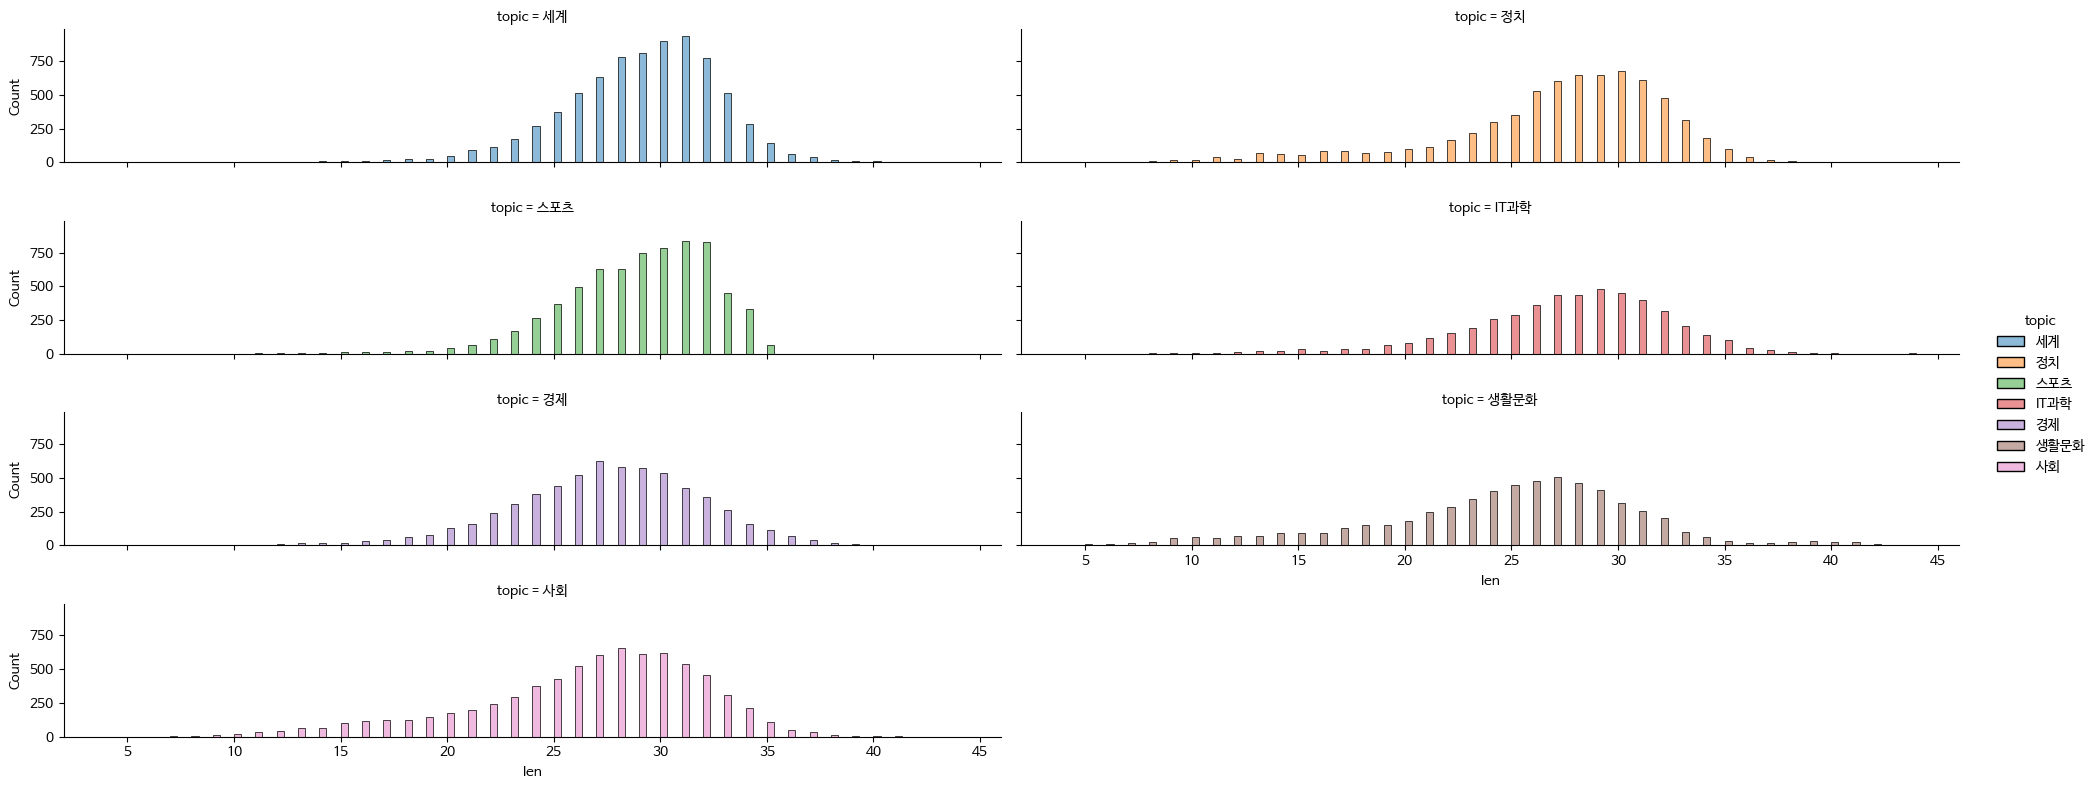

In [14]:
# 문장 길이
sns.displot(data = train_df, x = "len", hue = "topic", col = "topic",
            col_wrap = 2, height = 2, aspect = 5)

## ***preprocessing***

### 1. 품사 태깅 및 어간 추출

In [15]:
kkma = Kkma()
okt = Okt()
komoran = Komoran()

In [16]:
## 세가지 형태소 분석기 kkma, okt, komoran overview

for i in range(5):
  train_i = train_df['title'][i]
  test_kkma = kkma.pos(train_i)
  test_okt = okt.pos(train_i)
  test_komoran = komoran.pos(train_i)
  print("kkma    : ", test_kkma)
  print("okt     : ", test_okt)
  print("komoran : ", test_komoran)
  print('\n')

kkma    :  [('인천', 'NNG'), ('→', 'SW'), ('핀란드', 'NNG'), ('항공기', 'NNG'), ('결항', 'NNG'), ('…', 'SE'), ('휴가', 'NNG'), ('철', 'NNG'), ('여행객', 'NNG'), ('분통', 'NNG')]
okt     :  [('인천', 'Noun'), ('→', 'Foreign'), ('핀란드', 'Noun'), ('항공기', 'Noun'), ('결항', 'Noun'), ('…', 'Punctuation'), ('휴가', 'Noun'), ('철', 'Noun'), ('여행객', 'Noun'), ('분통', 'Noun')]
komoran :  [('인천', 'NNP'), ('→', 'SW'), ('핀란드', 'NNP'), ('항공기', 'NNP'), ('결', 'NNG'), ('항', 'NNG'), ('…', 'SE'), ('휴가철', 'NNG'), ('여행객', 'NNG'), ('분통', 'NNG')]


kkma    :  [('실리콘', 'NNG'), ('밸리', 'NNG'), ('넘어서', 'VV'), ('겠', 'EPT'), ('다', 'ECS'), ('…', 'SE'), ('구', 'NNG'), ('글', 'NNG'), ('15', 'NR'), ('조', 'NR'), ('원', 'NNM'), ('들이', 'VV'), ('어', 'ECS'), ('美', 'OH'), ('전역', 'NNG'), ('거점', 'NNG'), ('화', 'XSN')]
okt     :  [('실리콘밸리', 'Noun'), ('넘어서겠다', 'Verb'), ('…', 'Punctuation'), ('구글', 'Noun'), ('15조원', 'Number'), ('들여', 'Verb'), ('美', 'Foreign'), ('전역', 'Noun'), ('거점', 'Noun'), ('화', 'Suffix')]
komoran :  [('실리콘밸리', 'NNP'), ('넘어서', 'VV'), ('겠', '

In [17]:
## 속도 측면에서 이점이 확실한 okt 사용

def pos_cleaner(str):
  result = []
  for s in okt.pos(str, stem=True):
    # 관형사, 조사, 어미, 구두점, 접미사, 한국어 자음-모음 을 제외한 나머지 품사는 결과에 넣어줌
    if s[1] not in ["Determiner", "Josa", "Emoi", "Punctuation", "Suffix", "KoreanParticle"]:
      result.append(s[0])
  return " ".join(result)

### 2. 데이터 정제

In [20]:
## 품사 태깅으로 처리되지 않은 기타 기본적인 텍스트 정제

def text_preprocessor(s):
    import re

    ## (1) [], (), {}, <> 괄호와 괄호 안 문자 제거하기
    pattern = r'\([^)]*\)'  # ()
    s = re.sub(pattern=pattern, repl='', string=s)

    pattern = r'\[[^)]*\]'  # []
    s = re.sub(pattern=pattern, repl='', string=s)

    pattern = r'\<[^)]*\>'  # <>
    s = re.sub(pattern=pattern, repl='', string=s)

    pattern = r'\{[^)]*\}'  # {}
    s = re.sub(pattern=pattern, repl='', string=s)

    ## (2) '...외', '...총' 제거하기
    s = s.replace('...외', ' ')
    s = s.replace('...총', ' ')

    ## (3) 단위 제거: cm, km, etc.
    units = ['mm', 'cm', 'km', 'ml', 'kg', 'g']
    for unit in units:
        s = s.lower() # 대문자를 소문자로 변환
        s = s.replace(unit, '')

    ## (4) 한자 > 한국어 대체
    s = s.replace("外人","외국인")
    s = s.replace("日","일본")
    s = s.replace("美","미국")
    s = s.replace("北","북한")
    s = s.replace("英","영국")
    s = s.replace("中","중국")
    s = s.replace("與","여당")
    s = s.replace("靑","청와대")
    s = s.replace("野","야당")
    s = s.replace("伊","이탈리아")
    s = s.replace("韓","한국")
    s = s.replace("南","한국")
    s = s.replace("獨","독일")
    s = s.replace("佛","프랑스")
    s = s.replace("檢","검찰")
    s = s.replace("銀","은행")
    s = s.replace("亞","아시아")
    s = s.replace("人","사람")
    s = s.replace("孫","손혜원")
    s = s.replace("企","기업")
    s = s.replace("前","이전")
    s = s.replace("反","반대")
    s = s.replace("安","안철수")
    s = s.replace("展","전시회")
    s = s.replace("故","사망")
    s = s.replace("文","문재인")
    s = s.replace("新","새로운")
    s = s.replace("曺","조국")
    s = s.replace("朴","박근혜")
    s = s.replace("株","주식")
    s = s.replace("男","남자")
    s = s.replace("硏","연구")
    s = s.replace("車","자동차")
    s = s.replace("軍","군대")
    s = s.replace("重","중공업")

    ## (5) 특수문자 제거
    pattern = r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-z]'
    s = re.sub(pattern=pattern, repl=' ', string=s)

    return s

### 3. 불용어 처리

In [21]:
## 구글링으로 긁어온 한국어 전처리에 자주 사용되는 불용어 모음

stop_words = "아 종합 년 월 일 원 조원 억원 더 일 십 백 천 만 조 억 개 보 것 수 데 첫 국 개국 안 하다 등 외 못 안 달 의 후 전 우리 분 그리고 및 그 제 더 하는 한다 없 아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓"
stop_words = stop_words.split(' ')

def del_stop_words(s):
  seq = s.split(' ')
  result = []
  for w in seq:
      if w not in stop_words:
        if len(w) != 1:
          result.append(w)
  return ' '.join(result)

In [22]:
## train_df 데이터셋 전처리

train_df["clean_title"] = train_df["title"].apply(lambda x: pos_cleaner(x))
train_df["clean_title"] = train_df["clean_title"].apply(lambda x: text_preprocessor(x))
train_df["clean_title"] = train_df["clean_title"].apply(lambda x: del_stop_words(x))

train_df.head(10)

,index,title,topic_idx,topic,len,word_cnt,clean_title
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계,24,5,인천 핀란드 항공기 결항 휴가 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,세계,30,6,실리콘밸리 넘어서다 구글 들이다 미국 전역 거점
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,세계,30,8,이란 외무 긴장 완화 해결 미국 경제 전쟁 멈추다
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,세계,32,7,nyt 클린턴 측근 한국 기업 특수 관계 조명 공과 맞다 물리다
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,세계,25,7,시진핑 트럼프 중미 무역 협상 조속 타결 희망
5,5,팔레스타인 가자지구서 16세 소년 이스라엘군 총격에 사망,4,세계,31,7,팔레스타인 가자지구 소년 이스라엘군 총격 사망
6,6,인도 48년 만에 파키스탄 공습…테러 캠프 폭격종합2보,4,세계,30,7,인도 파키스탄 공습 테러 캠프 폭격
7,7,美대선 TV토론 음담패설 만회실패 트럼프…사과 대신 빌클린턴 공격해 역효과,4,세계,41,9,미국 대선 tv 토론 음담패설 만회 실패 트럼프 사과 대신 빌다 클린턴 공격 역효과
8,8,푸틴 한반도 상황 진전 위한 방안 김정은 위원장과 논의,4,세계,30,9,푸틴 한반도 상황 진전 방안 김정은 위원장 논의
9,9,특검 면죄부 받은 트럼프 스캔들 보도 언론 맹공…국민의 적,4,세계,32,9,특검 면죄부 받다 트럼프 스캔들 보도 언론 맹공 국민


In [23]:
## test_df 데이터셋 전처리

test_df["clean_title"] = test_df["title"].apply(lambda x: pos_cleaner(x))
test_df["clean_title"] = test_df["clean_title"].apply(lambda x: text_preprocessor(x))
test_df["clean_title"] = test_df["clean_title"].apply(lambda x: del_stop_words(x))

test_df.head(10)

,index,title,clean_title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영,유튜브 내달 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다 흐려지다 남부 지방 옅다 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다,내년 국가 rd 평가 논문 건수 반영
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,김명자 신임 과총 회장 원로 젊다 과학자 지혜 모으다
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,회색 인간 작가 동식 양심 고백 소설 추다
5,45659,야외서 생방송 하세요…액션캠 전용 요금제 잇따라,야외 생방송 액션 전용 금제 잇따르다
6,45660,월드컵 태극전사 16강 전초기지 레오강 입성종합,월드컵 태극전사 초기 레오 입성
7,45661,미세먼지 속 출근길,미세먼지 출근길
8,45662,왓츠앱稅 230원에 성난 레바논 민심…총리사퇴로 이어져종합2보,왓츠앱 성나다 레바논 민심 총리 사퇴 이어지다
9,45663,베트남 경제 고성장 지속…2분기 GDP 6.71% 성장,베트남 경제 성장 지속 dp 성장


In [24]:
# wordcloud 및 정수 인코딩용 데이터프레임
def text_to_seq(s):
  seq = s.split(' ')
  seq = list(filter(None, seq))
  return seq

train_df["title_list"] = train_df["clean_title"].apply(lambda x : text_to_seq(x))
train_df.head(10)

,index,title,topic_idx,topic,len,word_cnt,clean_title,title_list
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계,24,5,인천 핀란드 항공기 결항 휴가 여행객 분통,"[인천, 핀란드, 항공기, 결항, 휴가, 여행객, 분통]"
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,세계,30,6,실리콘밸리 넘어서다 구글 들이다 미국 전역 거점,"[실리콘밸리, 넘어서다, 구글, 들이다, 미국, 전역, 거점]"
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,세계,30,8,이란 외무 긴장 완화 해결 미국 경제 전쟁 멈추다,"[이란, 외무, 긴장, 완화, 해결, 미국, 경제, 전쟁, 멈추다]"
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,세계,32,7,nyt 클린턴 측근 한국 기업 특수 관계 조명 공과 맞다 물리다,"[nyt, 클린턴, 측근, 한국, 기업, 특수, 관계, 조명, 공과, 맞다, 물리다]"
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,세계,25,7,시진핑 트럼프 중미 무역 협상 조속 타결 희망,"[시진핑, 트럼프, 중미, 무역, 협상, 조속, 타결, 희망]"
5,5,팔레스타인 가자지구서 16세 소년 이스라엘군 총격에 사망,4,세계,31,7,팔레스타인 가자지구 소년 이스라엘군 총격 사망,"[팔레스타인, 가자지구, 소년, 이스라엘군, 총격, 사망]"
6,6,인도 48년 만에 파키스탄 공습…테러 캠프 폭격종합2보,4,세계,30,7,인도 파키스탄 공습 테러 캠프 폭격,"[인도, 파키스탄, 공습, 테러, 캠프, 폭격]"
7,7,美대선 TV토론 음담패설 만회실패 트럼프…사과 대신 빌클린턴 공격해 역효과,4,세계,41,9,미국 대선 tv 토론 음담패설 만회 실패 트럼프 사과 대신 빌다 클린턴 공격 역효과,"[미국, 대선, tv, 토론, 음담패설, 만회, 실패, 트럼프, 사과, 대신, 빌다..."
8,8,푸틴 한반도 상황 진전 위한 방안 김정은 위원장과 논의,4,세계,30,9,푸틴 한반도 상황 진전 방안 김정은 위원장 논의,"[푸틴, 한반도, 상황, 진전, 방안, 김정은, 위원장, 논의]"
9,9,특검 면죄부 받은 트럼프 스캔들 보도 언론 맹공…국민의 적,4,세계,32,9,특검 면죄부 받다 트럼프 스캔들 보도 언론 맹공 국민,"[특검, 면죄부, 받다, 트럼프, 스캔들, 보도, 언론, 맹공, 국민]"


### 4. Topic 별 단어 분포 시각화 (Word Cloud)

[('출시', 515), ('개발', 421), ('kt', 359), ('삼성', 347), ('ai', 346), ('기술', 330), ('갤럭시', 279), ('네이버', 223), ('서비스', 216), ('개다', 214), ('skt', 213), ('스마트폰', 188), ('공개', 180), ('노트', 167), ('게시판', 156), ('카카오', 144), ('한국', 144), ('sk', 138), ('구글', 137), ('국내', 134), ('인공', 133), ('모바일', 132), ('로봇', 128), ('지능', 124), ('아이폰', 124), ('연구', 121), ('게임', 121), ('스마트', 114), ('lu', 111), ('세계', 110), ('텔레콤', 105), ('mwc', 92), ('애플', 92), ('인터넷', 91), ('보다', 90), ('데이터', 86), ('과학기술', 83), ('만원', 78), ('성공', 77), ('시장', 76)]
[('투자', 486), ('영업', 444), ('증권', 416), ('금융', 343), ('삼성', 325), ('코스피', 317), ('작년', 305), ('특징', 243), ('대출', 229), ('출시', 221), ('실적', 219), ('증가', 217), ('주식', 210), ('상승', 207), ('하락', 202), ('한국', 197), ('시장', 193), ('은행', 188), ('기업', 187), ('금리', 186), ('주택', 181), ('목표', 178), ('최대', 175), ('대다', 173), ('게시판', 165), ('그래픽', 164), ('펀드', 161), ('이익', 159), ('올해', 156), ('규모', 154), ('달러', 151), ('결정', 150), ('감소', 150), ('아파트', 143), ('현대', 142), ('코스닥', 128

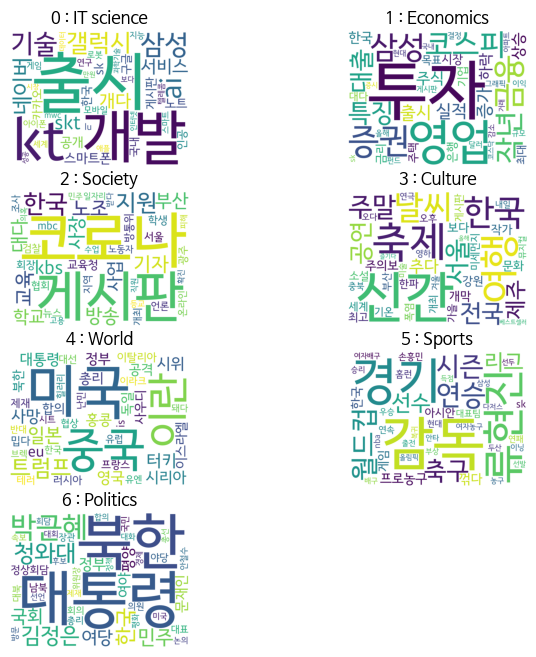

In [25]:
# 변수 동적 할당 (아래 밑줄 에러 무시)
for i in range(7):
  result = []
  title_list = train_df[train_df["topic_idx"] == i]["title_list"]
  for seq in title_list:
    for s in seq:
      result.append(s)

  globals()['tags_%d'%i] = Counter(result).most_common(40)
  globals()['tags_keys_%d'%i] = [key for key, _ in Counter(result).most_common(20)]

print(tags_0)
print(tags_1)
print(tags_2)
print(tags_3)
print(tags_4)
print(tags_5)
print(tags_6)


cloud_0 = WordCloud(font_path='/content/drive/MyDrive/KUBIG-DLcontest/Preprocessing/KakaoOTFRegular.otf', background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_0))
cloud_1 = WordCloud(font_path='/content/drive/MyDrive/KUBIG-DLcontest/Preprocessing/KakaoOTFRegular.otf', background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_1))
cloud_2 = WordCloud(font_path='/content/drive/MyDrive/KUBIG-DLcontest/Preprocessing/KakaoOTFRegular.otf', background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_2))
cloud_3 = WordCloud(font_path='/content/drive/MyDrive/KUBIG-DLcontest/Preprocessing/KakaoOTFRegular.otf', background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_3))
cloud_4 = WordCloud(font_path='/content/drive/MyDrive/KUBIG-DLcontest/Preprocessing/KakaoOTFRegular.otf', background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_4))
cloud_5 = WordCloud(font_path='/content/drive/MyDrive/KUBIG-DLcontest/Preprocessing/KakaoOTFRegular.otf', background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_5))
cloud_6 = WordCloud(font_path='/content/drive/MyDrive/KUBIG-DLcontest/Preprocessing/KakaoOTFRegular.otf', background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_6))

plt.figure(figsize = (8, 8))

plt.subplot(4, 2, 1)
plt.imshow(cloud_0)
plt.axis("off")
plt.title('0 : IT science')

plt.subplot(4, 2, 2)
plt.imshow(cloud_1)
plt.axis("off")
plt.title('1 : Economics')

plt.subplot(4, 2, 3)
plt.imshow(cloud_2)
plt.axis("off")
plt.title('2 : Society')

plt.subplot(4, 2, 4)
plt.imshow(cloud_3)
plt.axis("off")
plt.title('3 : Culture')

plt.subplot(4, 2, 5)
plt.imshow(cloud_4)
plt.axis("off")
plt.title('4 : World')

plt.subplot(4, 2, 6)
plt.imshow(cloud_5)
plt.axis("off")
plt.title('5 : Sports')

plt.subplot(4, 2, 7)
plt.imshow(cloud_6)
plt.axis("off")
plt.title('6 : Politics')


plt.show()

## '종합' 같은 키워드는 topic을 불문하고 다수 등장하는 것으로 보아, 추가적인 처리가 필요해보임

In [26]:
## 데이터셋에서 가장 빈번하게 등장하는 단어 30개 : most_common_30
## topic 별 가장 빈번히 등장하는 단어 상위 20개씩 모아놓은 list : all_topics_top_20
## 30개의 최다 단어들을 순회하며 토픽별 등장 빈도가 절반이 넘으면 의미없는 단어로 여기고 제외시킴

all_words_list = FreqDist(np.hstack(train_df["title_list"]))
most_common_30 = all_words_list.most_common(30)

def cnt_duplicating_topics(seq):
  result = []
  all_topics_top_20 = [tags_keys_0, tags_keys_1, tags_keys_2, tags_keys_3, tags_keys_4, tags_keys_5, tags_keys_6]
  for i in range(30):
    cnt = 0
    common_word = seq[i][0]
    for j in all_topics_top_20:
      if common_word in j:
        cnt += 1
    if cnt >= 3:
      result.append(common_word)
  return result

cnt_duplicating_topics(most_common_30)
## 결과인 "종합", "한국"은 불용어에 추가하겠습니다.
## + "억원", "조원"도 불용어에 추가하도록 하겠습니다.

['한국']

In [27]:
print("IT과학 : ", tags_0)
print("경제 : ", tags_1)
print("사회 : ", tags_2)
print("문화 : ", tags_3)
print("세계 : ", tags_4)
print("운동 : ", tags_5)
print("정치 : ", tags_6)

IT과학 :  [('출시', 515), ('개발', 421), ('kt', 359), ('삼성', 347), ('ai', 346), ('기술', 330), ('갤럭시', 279), ('네이버', 223), ('서비스', 216), ('개다', 214), ('skt', 213), ('스마트폰', 188), ('공개', 180), ('노트', 167), ('게시판', 156), ('카카오', 144), ('한국', 144), ('sk', 138), ('구글', 137), ('국내', 134), ('인공', 133), ('모바일', 132), ('로봇', 128), ('지능', 124), ('아이폰', 124), ('연구', 121), ('게임', 121), ('스마트', 114), ('lu', 111), ('세계', 110), ('텔레콤', 105), ('mwc', 92), ('애플', 92), ('인터넷', 91), ('보다', 90), ('데이터', 86), ('과학기술', 83), ('만원', 78), ('성공', 77), ('시장', 76)]
경제 :  [('투자', 486), ('영업', 444), ('증권', 416), ('금융', 343), ('삼성', 325), ('코스피', 317), ('작년', 305), ('특징', 243), ('대출', 229), ('출시', 221), ('실적', 219), ('증가', 217), ('주식', 210), ('상승', 207), ('하락', 202), ('한국', 197), ('시장', 193), ('은행', 188), ('기업', 187), ('금리', 186), ('주택', 181), ('목표', 178), ('최대', 175), ('대다', 173), ('게시판', 165), ('그래픽', 164), ('펀드', 161), ('이익', 159), ('올해', 156), ('규모', 154), ('달러', 151), ('결정', 150), ('감소', 150), ('아파트', 143), ('현대', 142

In [28]:
stop_words_v2 = ["종합", "한국", "억원", "조원"]

def del_stop_words_v2(s):
  seq = s.split(' ')
  result = []
  for w in seq:
      if w not in stop_words_v2:
        if len(w) != 1:
          result.append(w)
  return ' '.join(result)

In [29]:
## 최다 등장 단어 제거 후 최종 데이터 프레임

train_df["clean_title"] = train_df["clean_title"].apply(lambda x: del_stop_words_v2(x))
test_df["clean_title"] = test_df["clean_title"].apply(lambda x: del_stop_words_v2(x))
train_df["title_list"] = train_df["clean_title"].apply(lambda x : text_to_seq(x))
test_df["title_list"] = test_df["clean_title"].apply(lambda x : text_to_seq(x))

In [30]:
train_df.head()

,index,title,topic_idx,topic,len,word_cnt,clean_title,title_list
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계,24,5,인천 핀란드 항공기 결항 휴가 여행객 분통,"[인천, 핀란드, 항공기, 결항, 휴가, 여행객, 분통]"
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,세계,30,6,실리콘밸리 넘어서다 구글 들이다 미국 전역 거점,"[실리콘밸리, 넘어서다, 구글, 들이다, 미국, 전역, 거점]"
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,세계,30,8,이란 외무 긴장 완화 해결 미국 경제 전쟁 멈추다,"[이란, 외무, 긴장, 완화, 해결, 미국, 경제, 전쟁, 멈추다]"
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,세계,32,7,nyt 클린턴 측근 기업 특수 관계 조명 공과 맞다 물리다,"[nyt, 클린턴, 측근, 기업, 특수, 관계, 조명, 공과, 맞다, 물리다]"
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,세계,25,7,시진핑 트럼프 중미 무역 협상 조속 타결 희망,"[시진핑, 트럼프, 중미, 무역, 협상, 조속, 타결, 희망]"


In [ ]:
test_df.head()

,index,title,clean_title,title_list
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영,유튜브 내달 크리에이터 지원 공간 운영,"[유튜브, 내달, 크리에이터, 지원, 공간, 운영]"
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다 흐려지다 남부 지방 옅다 황사,"[어버이날, 맑다, 흐려지다, 남부, 지방, 옅다, 황사]"
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다,내년 국가 rd 평가 논문 건수 반영,"[내년, 국가, rd, 평가, 논문, 건수, 반영]"
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,김명자 신임 과총 회장 원로 젊다 과학자 지혜 모으다,"[김명자, 신임, 과총, 회장, 원로, 젊다, 과학자, 지혜, 모으다]"
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,회색 인간 작가 동식 양심 고백 소설 추다,"[회색, 인간, 작가, 동식, 양심, 고백, 소설, 추다]"


In [ ]:
# roberta용 csv 파일화
train_df.to_csv("/content/drive/MyDrive/23-2 Kubig Contest/KUBIG-DLcontest/dataset/roberta_train_df.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/23-2 Kubig Contest/KUBIG-DLcontest/dataset/roboerta_test_df.csv", index=False)

In [ ]:
# 최종 전처리 완료 csv 파일화
train_df.to_csv("/content/drive/MyDrive/23-2 Kubig Contest/KUBIG-DLcontest/dataset/train_df.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/23-2 Kubig Contest/KUBIG-DLcontest/dataset/test_df.csv", index=False)

### 5. 정수 인코딩 및 패딩

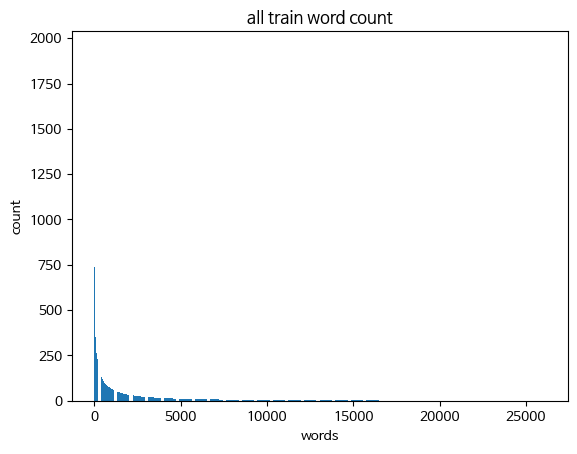

In [37]:
## 위에서 계산한 방식처럼, 빈도수를 기준으로 정수 인코딩 진행

# ## 단어 빈도 수가 얼마나 남아야할지 감이 잘 안잡혀서 한 번 진행해봤습니다.
# # words = np.hstack(preprocessed_sentences)으로도 수행 가능.
# all_words_list = dict(FreqDist(np.hstack(train_df["title_list"])))
# test = pd.DataFrame([all_words_list]).transpose()
# test.columns = ["cnt"]
# test.sort_values("cnt", ascending=False)

# test = test[test["cnt"] > 1]
# test

all_words_list = dict(FreqDist(np.hstack(train_df["title_list"])))
all_words_list = dict(sorted(all_words_list.items(), key=lambda item: item[1], reverse=True))

# 그래프 그리기
# keys = list(all_words_list.keys())
values = list(all_words_list.values())

plt.bar(range(len(values)), values)
plt.xlabel('words')
plt.ylabel('count')
plt.title('all train word count')
plt.show()

In [48]:
len(all_words_list.keys())

26124

In [46]:
## 시각화가 좀 이상하게 된 것 같아서 statics 패키지로 통계량 좀 다시 구해보겠습니다.

print(f"단어빈도 평균값: {statistics.mean(values)}")
print(f"단어빈도 중앙값: {statistics.median(values)}")
print(f"단어빈도 표준편차: {statistics.stdev(values)}")
print(f"단어빈도 분산: {statistics.variance(values)}")
print(f"단어빈도 최댓값: {max(values)}")
print(f"단어빈도 최솟값: {min(values)}")



단어빈도 평균값: 12.392129842290615
단어빈도 중앙값: 2.0
단어빈도 표준편차: 43.00688370670696
단어빈도 분산: 1849.5920461622163
단어빈도 최댓값: 1942
단어빈도 최솟값: 1


In [31]:
train_words_list = list(train_df["title_list"])
test_words_list = list(test_df["title_list"])

In [50]:
## train, test 의 title_list의 길이를 구하려고 합니다.

train_len_list = []
for seq in train_words_list:
  train_len_list.append(len(seq))

test_len_list = []
for seq in test_words_list:
    test_len_list.append(len(seq))

print(f'train데이터 길이평균값: {statistics.mean(train_len_list)} , test데이터 길이평균값: {statistics.mean(test_len_list)}')
print(f'train데이터 길이중앙값: {statistics.median(train_len_list)} , test데이터 길이중앙값: {statistics.median(test_len_list)}')
print(f'train데이터 길이표준편차: {statistics.stdev(train_len_list)} , test데이터 길이표준편차: {statistics.stdev(test_len_list)}')
print(f'train데이터 길이분산: {statistics.variance(train_len_list)} , test데이터 길이분산: {statistics.variance(test_len_list)}')
print(f'train데이터 길이최대: {max(train_len_list)} , test데이터 길이최대: {max(test_len_list)}')
print(f'train데이터 길이최소: {min(train_len_list)} , test데이터 길이최소: {min(test_len_list)}')


train데이터 길이평균값: 7.090988741402725 , test데이터 길이평균값: 7.050596867812945
train데이터 길이중앙값: 7.0 , test데이터 길이중앙값: 7
train데이터 길이표준편차: 1.742811369524478 , test데이터 길이표준편차: 1.7197590271310488
train데이터 길이분산: 3.0373914697437865 , test데이터 길이분산: 2.9575711113987317
train데이터 길이최대: 15 , test데이터 길이최대: 14
train데이터 길이최소: 0 , test데이터 길이최소: 1


In [71]:
# 구글링으로 긁어온 keras의 tokenizer 사용 예시
# https://wonhwa.tistory.com/35
# https://wikidocs.net/31766

# 인덱스 벡터 변환 후 일정 길이 넘어가거나 모자라는 리뷰 패딩처리
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_words_list)

train_sequences = tokenizer.texts_to_sequences(train_words_list)
test_sequences = tokenizer.texts_to_sequences(test_words_list)

word_vocab = tokenizer.word_index # 단어 사전 형태
MAX_SEQUENCE_LENGTH = 15 # Note : 문장 최대 길이를 설정하는 옵션인데, 바로 위 통계치 계산에서 가장 큰 값을 임의로 대입

In [72]:
#학습 데이터
train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

#학습 데이터 라벨 벡터화
train_labels = np.array(train_df["topic_idx"])

#평가 데이터
test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [73]:
print("train_inputs length : ", len(train_inputs))
print("test_inputs length : ", len(test_inputs))

train_inputs length :  45654
test_inputs length :  9131


In [74]:
np.save('/content/drive/MyDrive/KUBIG-DLcontest/dataset/개정 후 전처리 결과물 (08 26)/X_train', train_inputs)
np.save('/content/drive/MyDrive/KUBIG-DLcontest/dataset/개정 후 전처리 결과물 (08 26)/Y_train', train_labels)
np.save('/content/drive/MyDrive/KUBIG-DLcontest/dataset/개정 후 전처리 결과물 (08 26)/X_test', test_inputs)